In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random
import math
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

# Essay outline and initial testing

In [2]:
heroes_data = pd.read_csv("hero-network.csv",names=['source','target'])
heroes_data.head()

,source,target
0,"LITTLE, ABNER",PRINCESS ZANDA
1,"LITTLE, ABNER",BLACK PANTHER/T'CHAL
2,BLACK PANTHER/T'CHAL,PRINCESS ZANDA
3,"LITTLE, ABNER",PRINCESS ZANDA
4,"LITTLE, ABNER",BLACK PANTHER/T'CHAL


In [3]:
G_heroes = nx.from_pandas_edgelist(heroes_data,'source','target')

In [4]:
print(len(G_heroes.nodes),len(G_heroes.edges))

6426 167219


In [5]:
# Converting back to dataframe now that networkx has removed multiple connections under the basis that a single connection between characters
# is sufficient to create an edge
heroes_data_cleaned = nx.to_pandas_edgelist(G_heroes)

In [6]:
heroes_data_cleaned.head()

,source,target
0,"LITTLE, ABNER",PRINCESS ZANDA
1,"LITTLE, ABNER",BLACK PANTHER/T'CHAL
2,"LITTLE, ABNER",CARNIVORE/COUNT ANDR
3,"LITTLE, ABNER",IRON MAN/TONY STARK
4,"LITTLE, ABNER",GOLDEN-BLADE


In [7]:
# Take some subset of the network; entire network is too large/high comp cost

Thor = heroes_data[heroes_data['source'].str.contains('DONALD BLAK')].sample(10)
SpiderM = heroes_data[heroes_data['source'].str.contains('SPIDER-MAN/PETER')].sample(10)
CapA = heroes_data[heroes_data['source'] == ('CAPTAIN AMERICA')].sample(10)
IronM = heroes_data[heroes_data['source'].str.contains('IRON MAN/TONY STARK')].sample(10)

In [8]:
heroes_subset = pd.concat([Thor,SpiderM,CapA,IronM],axis=0)

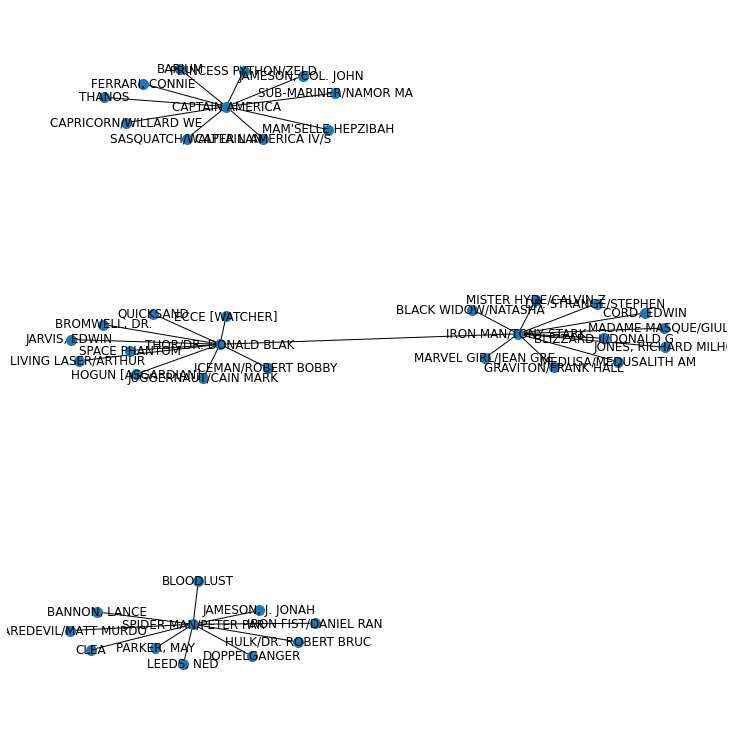

In [9]:
G_heroes_subset = nx.from_pandas_edgelist(heroes_subset,'source','target')
plt.figure(figsize = (10,10))
nx.draw(G_heroes_subset, with_labels=True,node_size=100)
plt.show()

# Begin project

#### Creating our dataset/network from raw data

* There are a few things to clear up in the data sets first
* Pick top 50 nodes/character based on the number of comic book appearances, using other datasets from kaggle.  
* Then shorten the hero-network.csv based on this subset of characters

https://www.kaggle.com/datasets/csanhueza/the-marvel-universe-social-network/code?select=edges.csv
https://www.kaggle.com/code/jaewook704/marvel-network

In [10]:
# Read in the data sets that we will need
hero_comics = pd.read_csv('edges.csv')
heroes_data = pd.read_csv("hero-network.csv",names=['source','target'])

In [11]:
# Note that we get an different output here to the box below.  This indicates that there are clearly
# some inconsistencies with naming for each of the data sets

# It seems that there all the names have a 20 character limit in the first data set displayed so we need to account for this;
# we will account for this later once we have drawn a subset of the characters
heroes_data[heroes_data['source'] == 'SPIDER-MAN/PETER PAR'].head(),hero_comics[hero_comics['hero'] == 'SPIDER-MAN/PETER PARKER'].head()

(                   source                target
 398  SPIDER-MAN/PETER PAR  FIRESTAR/ANGELICA JO
 399  SPIDER-MAN/PETER PAR  THUNDERBALL/DR. ELIO
 400  SPIDER-MAN/PETER PAR  NAMORITA/NITA PRENTI
 401  SPIDER-MAN/PETER PAR  SPEEDBALL/ROBBIE BAL
 402  SPIDER-MAN/PETER PAR  HULK/DR. ROBERT BRUC,
                           hero  comic
 75722  SPIDER-MAN/PETER PARKER   A 11
 75723  SPIDER-MAN/PETER PARKER  A 118
 75724  SPIDER-MAN/PETER PARKER  A 1.5
 75725  SPIDER-MAN/PETER PARKER  A 168
 75726  SPIDER-MAN/PETER PARKER  A 221)

In [12]:
# Finding out which heroes are the most popular by comic book appearances
num_chars = 50

comic_appearances = hero_comics.groupby(['hero']).count().sort_values(by='comic',ascending=False)
lst_popular_heroes = list(comic_appearances[:num_chars].index)

# Let's shorten the character count of the comic book character names to 20 or less
lst_popular_heroes = [x[:20] for x in lst_popular_heroes]

lst_popular_heroes_counts = list(comic_appearances['comic'].iloc[:num_chars])
popular_heroes = list(zip(lst_popular_heroes,lst_popular_heroes_counts))

# Let's have a look at the 10 most popular heroes
popular_heroes[:10]

[('SPIDER-MAN/PETER PAR', 1577),
 ('CAPTAIN AMERICA', 1334),
 ('IRON MAN/TONY STARK', 1150),
 ('THING/BENJAMIN J. GR', 963),
 ('THOR/DR. DONALD BLAK', 956),
 ('HUMAN TORCH/JOHNNY S', 886),
 ('MR. FANTASTIC/REED R', 854),
 ('HULK/DR. ROBERT BRUC', 835),
 ('WOLVERINE/LOGAN', 819),
 ('INVISIBLE WOMAN/SUE', 762)]

In [13]:
# issue here, name discrepancy between the 2 files ... issue here is that some names have a space as the 20th character

heroes_data['source'] = [x[:20].strip() for x in heroes_data['source']]
heroes_data['target'] = [x[:20].strip() for x in heroes_data['target']]

In [14]:
# get edges for subset of characters

lst_edges = []

for i in range(len(lst_popular_heroes)):
    for j in range(len(lst_popular_heroes)):
        if j != i:
            temp1 = heroes_data[heroes_data['source'] == lst_popular_heroes[i]]
            temp2 = temp1[temp1['target'] == lst_popular_heroes[j]]
            if temp2.empty:
                #print('no character interactions, isolated nodes')
                continue
            lst_edges.append(temp2)

In [15]:
new_edges = pd.DataFrame()

weight = []
node1 = []
node2 = []

for i in range(len(lst_edges)):
    weight.append(lst_edges[i].groupby(['source']).count().iloc[0,0])
    node1.append(lst_edges[i].iloc[0,0])
    node2.append(lst_edges[i].iloc[0,1])

new_edges['weight'] = weight
new_edges['node1'] = node1
new_edges['node2'] = node2

#### EDA

In [16]:
# New network, shortened to 50 most popular heroes
G = nx.from_pandas_edgelist(new_edges,'node1','node2', edge_attr='weight')

In [17]:
# Checking setup correctly
len(G.nodes) == 50, len(G.nodes), nx.get_edge_attributes(G,'weight')

(True,
 50,
 {('SPIDER-MAN/PETER PAR', 'CAPTAIN AMERICA'): 79,
  ('SPIDER-MAN/PETER PAR', 'IRON MAN/TONY STARK'): 54,
  ('SPIDER-MAN/PETER PAR', 'THING/BENJAMIN J. GR'): 70,
  ('SPIDER-MAN/PETER PAR', 'THOR/DR. DONALD BLAK'): 51,
  ('SPIDER-MAN/PETER PAR', 'HUMAN TORCH/JOHNNY S'): 80,
  ('SPIDER-MAN/PETER PAR', 'MR. FANTASTIC/REED R'): 63,
  ('SPIDER-MAN/PETER PAR', 'HULK/DR. ROBERT BRUC'): 50,
  ('SPIDER-MAN/PETER PAR', 'WOLVERINE/LOGAN'): 25,
  ('SPIDER-MAN/PETER PAR', 'INVISIBLE WOMAN/SUE'): 59,
  ('SPIDER-MAN/PETER PAR', 'SCARLET WITCH/WANDA'): 31,
  ('SPIDER-MAN/PETER PAR', 'BEAST/HENRY &HANK& P'): 28,
  ('SPIDER-MAN/PETER PAR', 'DR. STRANGE/STEPHEN'): 40,
  ('SPIDER-MAN/PETER PAR', 'WATSON-PARKER, MARY'): 321,
  ('SPIDER-MAN/PETER PAR', 'DAREDEVIL/MATT MURDO'): 56,
  ('SPIDER-MAN/PETER PAR', 'HAWK'): 33,
  ('SPIDER-MAN/PETER PAR', 'VISION'): 42,
  ('SPIDER-MAN/PETER PAR', 'CYCLOPS/SCOTT SUMMER'): 25,
  ('SPIDER-MAN/PETER PAR', 'WASP/JANET VAN DYNE'): 45,
  ('SPIDER-MAN/PETER PAR'

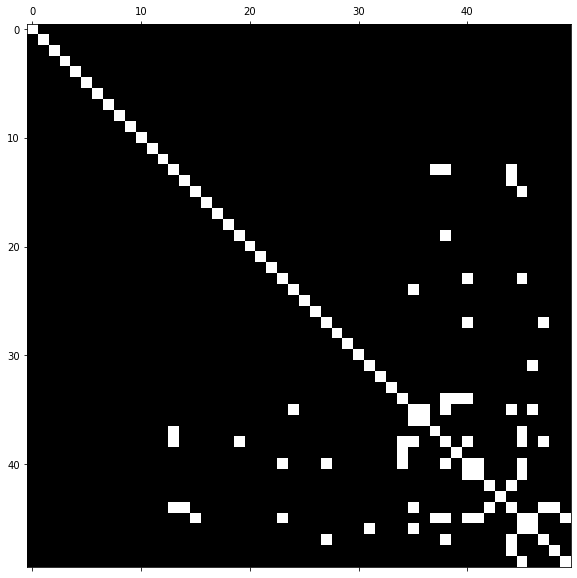

In [18]:
# Let's build the adjacency matrix

adj0 = nx.adjacency_matrix(G)
adj = adj0.todense()

plt.figure(figsize=(10,10))
plt.spy(adj)

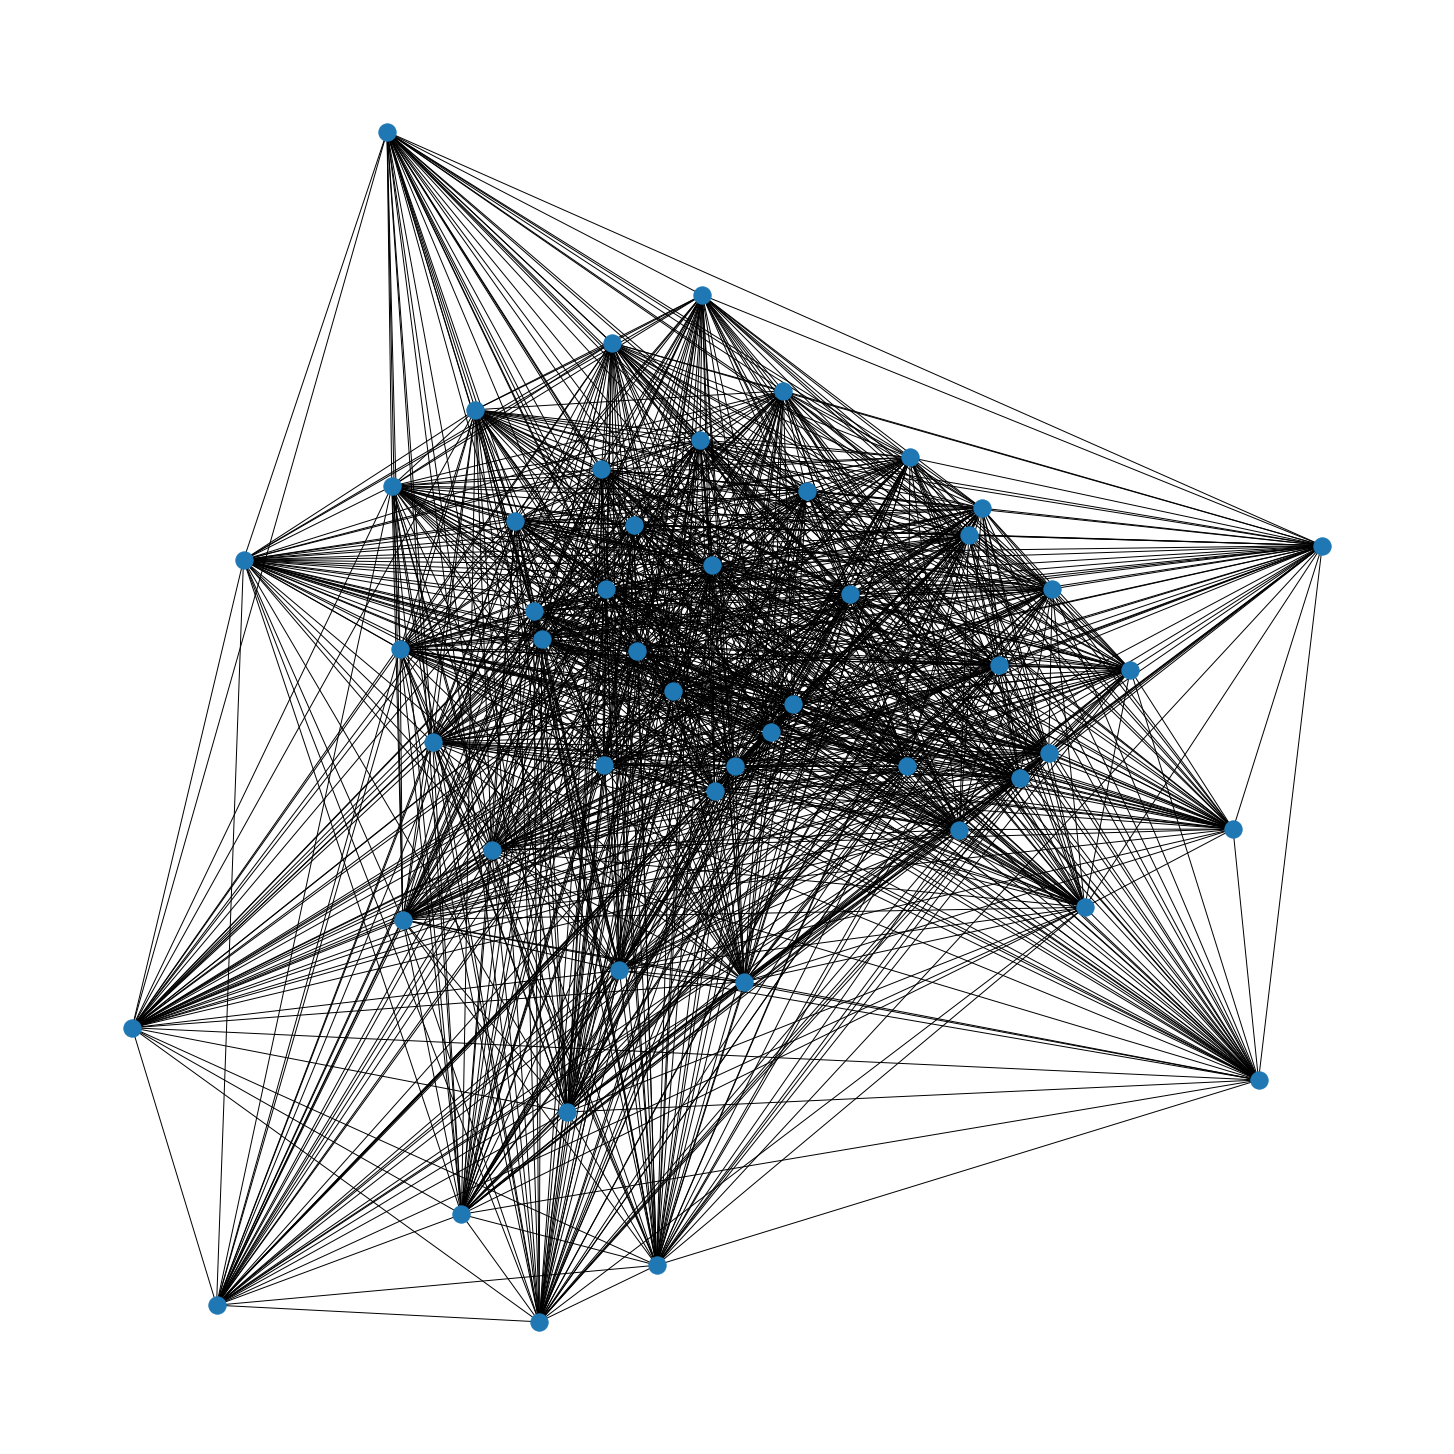

In [19]:
# Let's try and get a nice visualisation (network is quite dense so might prove tricky...)

plt.figure(figsize=(20,20))
pos = nx.spring_layout(G,seed=1)
nx.draw(G,pos=pos,font_color = 'black', with_labels = False)


In [20]:
# Degree sequences, distributions and histogram plots
degree_seq = np.array([b for x,b in nx.degree(G)])
freq_dist = np.bincount(degree_seq)
degrees = range(len(freq_dist))
pk = freq_dist/np.sum(freq_dist)
degree_seq, freq_dist, degrees, pk

(array([49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 46, 48, 48, 49,
        49, 49, 48, 49, 49, 49, 47, 48, 49, 49, 47, 49, 49, 49, 48, 49, 49,
        46, 44, 48, 47, 42, 48, 43, 47, 48, 49, 43, 41, 46, 46, 48, 48]),
 array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  1,  1,  2,  1,  0,  4,  4, 10, 27],
       dtype=int64),
 range(0, 50),
 array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.02, 0.04,
        0.02, 0.  , 0.08, 0.08, 0.2 , 0.54]))

Text(0.5, 0, 'log k')

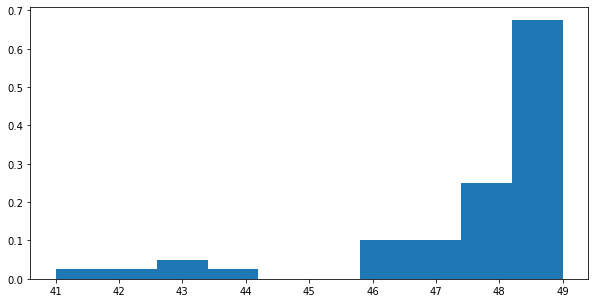

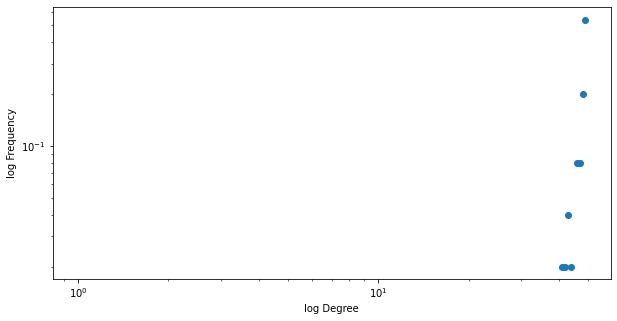

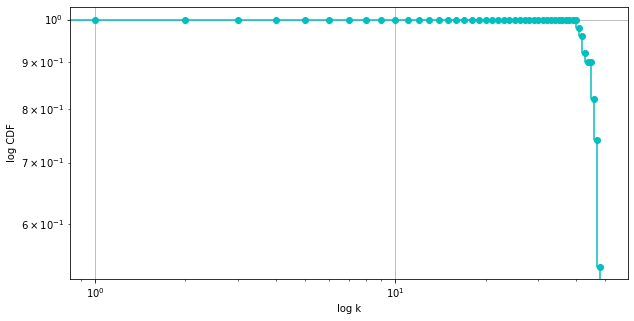

In [21]:
# degree sequence hist
plt.figure(figsize=(10, 5)) 
plt.hist(degree_seq,density=True)

#loglog scale of degree distribution, power law observed if straight line, seems so?
plt.figure(figsize=(10, 5)) 
plt.scatter(degrees,pk) 
plt.xscale('log')
plt.yscale('log')
plt.xlabel('log Degree')
plt.ylabel('log Frequency')

#CDF
plt.figure(figsize=(10,5))
plt.step(degrees,1-np.cumsum(pk),'co-') # or simply plt.loglog. Try it out.
plt.grid()
plt.xscale('log')
plt.yscale('log')
plt.ylabel("log CDF")
plt.xlabel("log k")

#### Apply community detection methods 

* Louvain

In [22]:
import networkx.algorithms.community as nx_comm

# applying Louvain
G_comm = nx_comm.louvain_communities(G,weight = 'weight', resolution = 1, threshold = 1e-07, seed = None)
G_comm

[{'DR. DOOM/VICTOR VON',
  'DR. STRANGE/STEPHEN',
  'HULK/DR. ROBERT BRUC',
  'HUMAN TORCH/JOHNNY S',
  'INVISIBLE WOMAN/SUE',
  'MR. FANTASTIC/REED R',
  'RICHARDS, FRANKLIN B',
  'SILVER SURFER/NORRIN',
  'SUB-MARINER/NAMOR MA',
  'THING/BENJAMIN J. GR'},
 {'DAREDEVIL/MATT MURDO',
  'JAMESON, J. JONAH',
  'NELSON, FRANKLIN FOG',
  'PARKER, MAY',
  'PUNISHER II/FRANK CA',
  'ROBERTSON, JOE',
  'SPIDER-MAN/PETER PAR',
  'WATSON-PARKER, MARY'},
 {'ANT-MAN/DR. HENRY J.',
  "BLACK PANTHER/T'CHAL",
  'BLACK WIDOW/NATASHA',
  'CAPTAIN AMERICA',
  'FURY, COL. NICHOLAS',
  'HAWK',
  'HERCULES [GREEK GOD]',
  'IRON MAN/TONY STARK',
  'JARVIS, EDWIN',
  'JONES, RICHARD MILHO',
  'ODIN [ASGARDIAN]',
  'QUICKSILVER/PIETRO M',
  'SCARLET WITCH/WANDA',
  'SHE-HULK/JENNIFER WA',
  'THOR/DR. DONALD BLAK',
  'VISION',
  'WASP/JANET VAN DYNE',
  'WONDER MAN/SIMON WIL'},
 {'ANGEL/WARREN KENNETH',
  'BEAST/HENRY &HANK& P',
  'CANNONBALL II/SAM GU',
  'CAPTAIN BRITAIN/BRIA',
  'COLOSSUS II/PETER RA',
  'C

In [23]:
# permute graph nodes via adjacency matrices so that it looks nice when visualising 
# CREDIT: functions taken from 
# https://github.com/YuetingH/MA4M4_2023/blob/3e27df087fbe19a9d6cc1d56348633f841d9b0d5/Support_Class2/SupportClass2.ipynb

# rearrange the graph so that decrease size clusters is the ordering
def rearrange_graph(G, comm):
    '''
    Input: 
        G: (un)directed (un)weighted graph
        comm: a list of sets, each of which comprises nodes belonging to the same community
    Output: 
        G_perm: it maintains the coherence of the input graph G, wherein nodes are rearranged to represent clusters of nodes within the corresponding community
    '''
    # Initialise an empty new graph with the same type as G
    G_perm = G.copy(); G_perm.clear() 
    
    # Arrange the sets in the comm list in a descending order based on the size of each set
    comm_copy = comm.copy(); # retain the input "comm" but copy it for use in this function 
    comm_copy.sort(key=len, reverse = True) 
    
    # Add nodes
    for comm_set in comm_copy:
        G_perm.add_nodes_from(list(comm_set))
    
    # Add edges
    for edge in G.edges.data():
        G_perm.add_edges_from([edge])
        
    return G_perm

# permute adjacency matrix, using previous function
def compute_perm_adj(G, comm):
    '''
    Input:
        G: (un)directed (un)weighted graph
        comm: a list of sets, each of which comprises nodes belonging to the same community
    Output:
        A_perm: permuted adjacency matrix
    '''
    G_perm = rearrange_graph(G, comm)
    A_perm = nx.adjacency_matrix(G_perm).todense()
    
    return A_perm

In [24]:
# permute graph nodes via adjacency matrices so that it looks nice when visualising 

A_perm = compute_perm_adj(G, G_comm)
adj, "==================================================", A_perm

(array([[  0,  79,  54, ...,  16,  28,  14],
        [ 79,   0, 226, ...,   5,  35,  20],
        [ 54, 226,   0, ...,   2,  18,  15],
        ...,
        [ 16,   5,   2, ...,   0,   2,   1],
        [ 28,  35,  18, ...,   2,   0,  15],
        [ 14,  20,  15, ...,   1,  15,   0]], dtype=int32),
 '==================================================',
 array([[  0,  59,  51, ...,   1,  12,   3],
        [ 59,   0, 169, ...,   1,  22,  14],
        [ 51, 169,   0, ...,   2,  19,  11],
        ...,
        [  1,   1,   2, ...,   0,  16,  10],
        [ 12,  22,  19, ...,  16,   0,  28],
        [  3,  14,  11, ...,  10,  28,   0]], dtype=int32))

Text(0.5, 1.0, 'Permuted Adjacency Matrix - LogTransform')

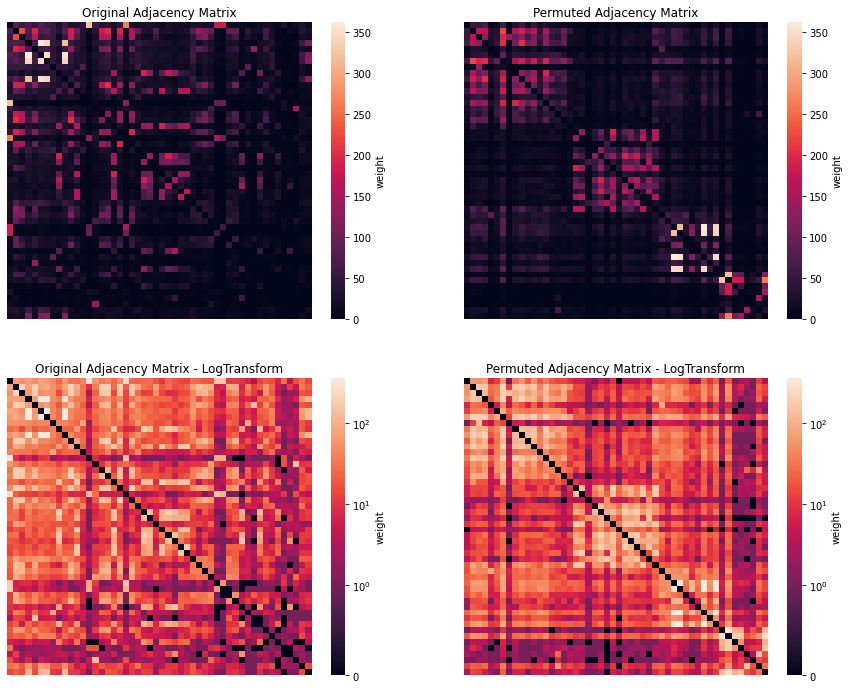

In [25]:
# visualise using seaborn
import seaborn as sns
from matplotlib.colors import LogNorm, SymLogNorm
A = nx.adjacency_matrix(G).todense() # We also get the original adjacency matrix of G for comparison
fig, axes = plt.subplots(2, 2, figsize = (15, 12))

sns.heatmap(A, xticklabels = 0, yticklabels = 0, ax = axes[0,0], cbar_kws={'label': 'weight'})
axes[0, 0].set_title('Original Adjacency Matrix')

sns.heatmap(A_perm, xticklabels = 0, yticklabels = 0, ax = axes[0,1], cbar_kws={'label': 'weight'})
axes[0, 1].set_title('Permuted Adjacency Matrix')

sns.heatmap(A, xticklabels = 0, yticklabels = 0, ax = axes[1,0], norm = SymLogNorm(1), cbar_kws={'label': 'weight'})
axes[1, 0].set_title('Original Adjacency Matrix - LogTransform')

sns.heatmap(A_perm, xticklabels = 0, yticklabels = 0, ax = axes[1,1], norm = SymLogNorm(1), cbar_kws={'label': 'weight'})
axes[1, 1].set_title('Permuted Adjacency Matrix - LogTransform')

In [26]:
G_comm[0] #fantastic four related

{'DR. DOOM/VICTOR VON',
 'DR. STRANGE/STEPHEN',
 'HULK/DR. ROBERT BRUC',
 'HUMAN TORCH/JOHNNY S',
 'INVISIBLE WOMAN/SUE',
 'MR. FANTASTIC/REED R',
 'RICHARDS, FRANKLIN B',
 'SILVER SURFER/NORRIN',
 'SUB-MARINER/NAMOR MA',
 'THING/BENJAMIN J. GR'}

In [27]:
G_comm[1] #avengers related

{'DAREDEVIL/MATT MURDO',
 'JAMESON, J. JONAH',
 'NELSON, FRANKLIN FOG',
 'PARKER, MAY',
 'PUNISHER II/FRANK CA',
 'ROBERTSON, JOE',
 'SPIDER-MAN/PETER PAR',
 'WATSON-PARKER, MARY'}

In [28]:
G_comm[2] #new york based, daredevil/spiderman

{'ANT-MAN/DR. HENRY J.',
 "BLACK PANTHER/T'CHAL",
 'BLACK WIDOW/NATASHA',
 'CAPTAIN AMERICA',
 'FURY, COL. NICHOLAS',
 'HAWK',
 'HERCULES [GREEK GOD]',
 'IRON MAN/TONY STARK',
 'JARVIS, EDWIN',
 'JONES, RICHARD MILHO',
 'ODIN [ASGARDIAN]',
 'QUICKSILVER/PIETRO M',
 'SCARLET WITCH/WANDA',
 'SHE-HULK/JENNIFER WA',
 'THOR/DR. DONALD BLAK',
 'VISION',
 'WASP/JANET VAN DYNE',
 'WONDER MAN/SIMON WIL'}

In [29]:
G_comm[3] # x-men/mutants

{'ANGEL/WARREN KENNETH',
 'BEAST/HENRY &HANK& P',
 'CANNONBALL II/SAM GU',
 'CAPTAIN BRITAIN/BRIA',
 'COLOSSUS II/PETER RA',
 'CYCLOPS/SCOTT SUMMER',
 'ICEMAN/ROBERT BOBBY',
 'MARVEL GIRL/JEAN GRE',
 'NIGHTCRAWLER/KURT WA',
 'PROFESSOR X/CHARLES',
 'ROGUE /',
 'SHADOWCAT/KATHERINE',
 'STORM/ORORO MUNROE S',
 'WOLVERINE/LOGAN'}

In [30]:
# Robustness assessment: associaton matrix

# CREDIT: functions taken from 
# https://github.com/YuetingH/MA4M4_2023/blob/3e27df087fbe19a9d6cc1d56348633f841d9b0d5/Support_Class2/SupportClass2.ipynb

# An association matrix is utilized to visualize the stochasticity of community detection, 
# changing resolution parameter/different scale of partition
# or comparing different instances or partitions.
# each entry in the matrix indicates the proportion of times two nodes are assigned to the same 
# community across a specified number of community detection runs. The matrix's diagonal values are always assigned a value of 1.
# Nodes are rearranged in accordance with the input community detection result, forming clusters of nodes within 
# the same community. As per usual, the order of these clusters is determined based on their size, 
# with larger clusters appearing first in the sequence

def compute_asso_one_run(G, perm_comm, seed):
    '''
    We create an unweighted dummy graph. An edge is generated if two nodes are assigned to the same community when performing community detection in graph G. 
    
    Input:
        G: (un)directed (un)weighted graph
        perm_comm: a list of sets, each of which comprises nodes belonging to the same community
        seed: random seed
    Output:
        A_dummy: a matrix indicates whether two nodes are assigned to the same community
    '''
    
    # community detection results
    G_comm = nx_comm.louvain_communities(G, seed = seed) 
    # get a graph with permuted nodes but no edges
    G_dummy = rearrange_graph(G, perm_comm); G_dummy.remove_edges_from(list(G_dummy.edges))
    
    for comm in G_comm:
        comm = list(comm)
        G_dummy_edges = [(a, b) for idx, a in enumerate(comm) for b in comm[idx + 0:]]
        G_dummy.add_edges_from(G_dummy_edges)
    A_dummy = nx.adjacency_matrix(G_dummy).todense()
    
    return A_dummy

def compute_asso(G, comm, n_runs, perm = True):
    '''
    Input:
        G: (un)directed (un)weighted graph
        comm: a list of sets, each of which comprises nodes belonging to the same community
        n_runs: the number of community detection runs
        perm: whether to permute association matrix according to comm
    Output:
        A_asso: a matrix indicates the proportion of times two nodes are assigned to the same community
    '''
    
    A_asso = np.zeros((len(G.nodes), len(G.nodes)))
    
    if perm:
        for i in range(n_runs):
            A_asso += compute_asso_one_run(G, comm, i)
    else:
        for i in range(n_runs):
            A_asso += compute_asso_one_run(G, [set(G.nodes)], i)
    A_asso /= n_runs
    
    return A_asso

Text(0.5, 1.0, 'Permuted Association Matrix')

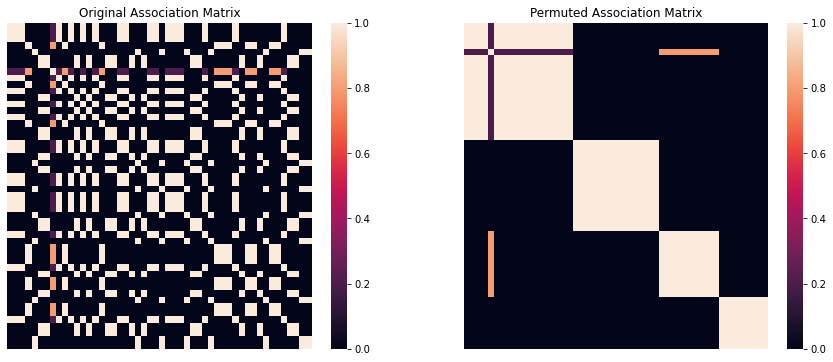

In [31]:
n_runs = 100
A_asso = compute_asso(G, G_comm, n_runs = n_runs, perm = False)
A_perm_asso = compute_asso(G, G_comm, n_runs = n_runs)
fig, axes = plt.subplots(1, 2, figsize = (15, 6))

sns.heatmap(A_asso, xticklabels = 0, yticklabels = 0, ax = axes[0])
axes[0].set_title('Original Association Matrix')

sns.heatmap(A_perm_asso, xticklabels = 0, yticklabels = 0, ax = axes[1])
axes[1].set_title('Permuted Association Matrix')

In [32]:
# Robustness assessment: nMI matrix

# CREDIT: functions taken from 
# https://github.com/YuetingH/MA4M4_2023/blob/3e27df087fbe19a9d6cc1d56348633f841d9b0d5/Support_Class2/SupportClass2.ipynb

# nMI is normalised mutual info.  Each value in the matrix represents the level of similarity
# between a pair of partition results, ranging from 0 to 1, where 1 means two partitions are entirely identical

def comm_detection_dict(G, seed):
    '''
    Input:
        G: (un)directed (un)weighted graph
        n_runs: the number of community detection runs
    Output:
        G_comm_dict: a dictionary format of {node: label}, where each label is an integer, and nodes with the same label are assigned to the same community.
    '''
    
    G_comm = nx_comm.louvain_communities(G, seed = seed)
    G_comm_dict = {node: 0 for node in G.nodes}
    
    index = 0
    for comm in G_comm:
        for node in comm:
            G_comm_dict[node] = index
        index += 1
        
    return G_comm_dict

Text(0.5, 1.0, 'nMI matrix')

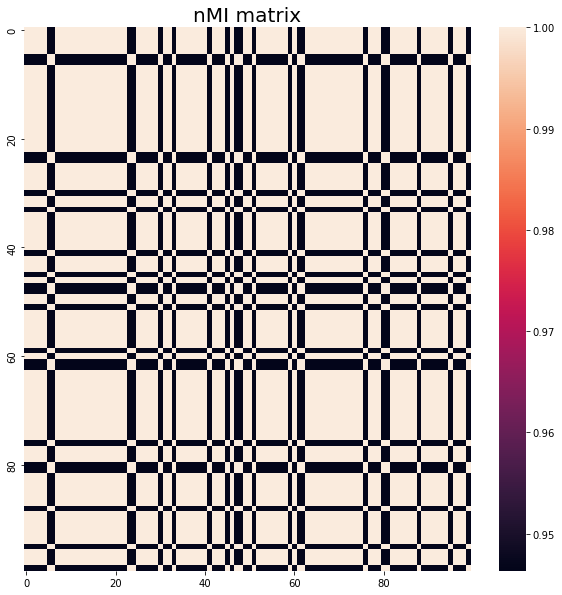

In [33]:
import sklearn
from sklearn import metrics

def compute_nMI(G, n_runs):
    '''
    Input:
        G: (un)directed (un)weighted graph
        n_runs: the number of community detection runs
    Output:
        nMI_matrix: a matrix indicates the similarity between different partitions
    '''
    
    # Obtain community results using different random seeds. Convert results to labels and save them in a numpy array.
    n_runs_labels = []
    for i in range(n_runs):
        label = np.array(list(comm_detection_dict(G, seed = i).values()))
        n_runs_labels.append(label)
    n_runs_labels = np.array(n_runs_labels)
    
    # Calculate the level of dissimilarity between each pair of partition results using NMI
    nMI_matrix = np.zeros((n_runs, n_runs))
    for i in range(n_runs):
        for j in range(n_runs):
            nMI_matrix[i, j] = sklearn.metrics.normalized_mutual_info_score(n_runs_labels[i], n_runs_labels[j])
    
    return nMI_matrix

nMI_matrix = compute_nMI(G, n_runs = 100)
plt.figure(figsize=(10,10))
sns.heatmap(nMI_matrix, xticklabels = 20, yticklabels = 20)
plt.title('nMI matrix', fontsize = 20)

#### Apply community detection methods 

* Leiden

https://pypi.org/project/leidenalg/

In [34]:
import igraph as ig
import leidenalg as la

In [35]:
# converting from networkx graph to igraph
H = ig.Graph.from_networkx(G)

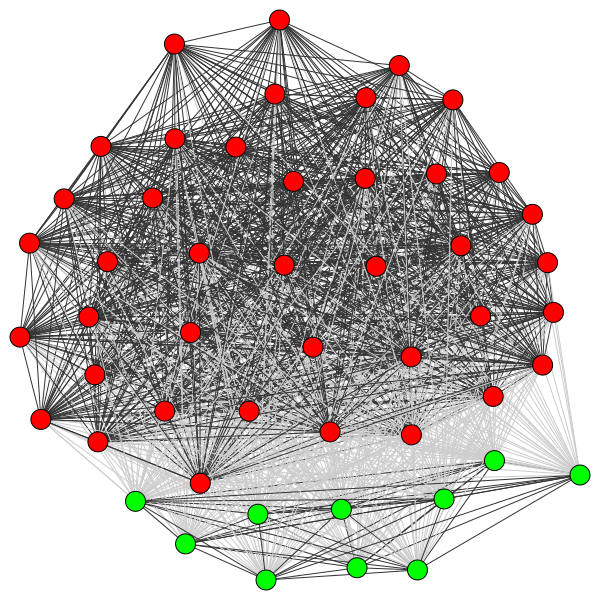

In [36]:
partition = la.find_partition(H,partition_type = la.ModularityVertexPartition, n_iterations = -1, max_comm_size = 0)
ig.plot(partition)

In [37]:
nodes_names = list(G.nodes)

comms_LD = list(partition)

for i in range(len(comms_LD)):
    for j in range(len(comms_LD[i])):
        comms_LD[i][j] = nodes_names[comms_LD[i][j]]
        

In [38]:
comms_LD[0]

['SPIDER-MAN/PETER PAR',
 'CAPTAIN AMERICA',
 'IRON MAN/TONY STARK',
 'THING/BENJAMIN J. GR',
 'THOR/DR. DONALD BLAK',
 'HUMAN TORCH/JOHNNY S',
 'MR. FANTASTIC/REED R',
 'HULK/DR. ROBERT BRUC',
 'WOLVERINE/LOGAN',
 'INVISIBLE WOMAN/SUE',
 'SCARLET WITCH/WANDA',
 'BEAST/HENRY &HANK& P',
 'DR. STRANGE/STEPHEN',
 'HAWK',
 'VISION',
 'CYCLOPS/SCOTT SUMMER',
 'WASP/JANET VAN DYNE',
 'ANT-MAN/DR. HENRY J.',
 'SUB-MARINER/NAMOR MA',
 'STORM/ORORO MUNROE S',
 'PROFESSOR X/CHARLES',
 'FURY, COL. NICHOLAS',
 'MARVEL GIRL/JEAN GRE',
 'COLOSSUS II/PETER RA',
 'NIGHTCRAWLER/KURT WA',
 'ANGEL/WARREN KENNETH',
 'ICEMAN/ROBERT BOBBY',
 'SHE-HULK/JENNIFER WA',
 'WONDER MAN/SIMON WIL',
 'BLACK WIDOW/NATASHA',
 'HERCULES [GREEK GOD]',
 'QUICKSILVER/PIETRO M',
 'SHADOWCAT/KATHERINE',
 'JONES, RICHARD MILHO',
 'ODIN [ASGARDIAN]',
 'ROGUE /',
 'SILVER SURFER/NORRIN',
 'CANNONBALL II/SAM GU',
 'CAPTAIN BRITAIN/BRIA',
 'RICHARDS, FRANKLIN B']

In [39]:
comms_LD[1]

['WATSON-PARKER, MARY',
 'DAREDEVIL/MATT MURDO',
 'JAMESON, J. JONAH',
 'JARVIS, EDWIN',
 'ROBERTSON, JOE',
 'PARKER, MAY',
 "BLACK PANTHER/T'CHAL",
 'PUNISHER II/FRANK CA',
 'NELSON, FRANKLIN FOG',
 'DR. DOOM/VICTOR VON']

Text(0.5, 1.0, 'Permuted Association Matrix')

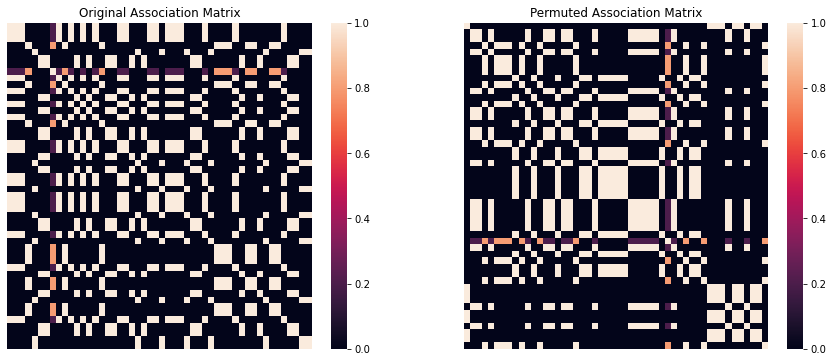

In [40]:
# Association matrix

n_runs = 100
A_asso = compute_asso(G, comms_LD, n_runs = n_runs, perm = False)
A_perm_asso = compute_asso(G, comms_LD, n_runs = n_runs)
fig, axes = plt.subplots(1, 2, figsize = (15, 6))

sns.heatmap(A_asso, xticklabels = 0, yticklabels = 0, ax = axes[0])
axes[0].set_title('Original Association Matrix')

sns.heatmap(A_perm_asso, xticklabels = 0, yticklabels = 0, ax = axes[1])
axes[1].set_title('Permuted Association Matrix')

#### Apply community detection methods 

* Girvan-Newman

In [86]:
def girvan_newman(G):
    # Calculate the betweenness centrality for all edges in G
    bet_cen = nx.edge_betweenness_centrality(G)

    while len(G.edges()) > 0:
        # Find the edge with the highest betweenness centrality
        max_bet_cen = max(bet_cen.values())
        edges = [edge for edge, bc in bet_cen.items() if bc == max_bet_cen]
        
        # Remove the edge(s) with the highest betweenness centrality
        G.remove_edges_from(edges)
        
        # Check if the graph is disconnected
        components = [comp for comp in nx.connected_components(G)]
        
        # If the graph is not disconnected, return the communities
        if len(components) > 1:
            return components
        
        # Recalculate the betweenness centrality for all edges in G
        bet_cen = nx.edge_betweenness_centrality(G)
        
    return None # If there are no edges left in the graph, return None


In [87]:
comms_GN = girvan_newman(G)

In [88]:
comms_GN[0]

{'ANGEL/WARREN KENNETH',
 'ANT-MAN/DR. HENRY J.',
 'BEAST/HENRY &HANK& P',
 "BLACK PANTHER/T'CHAL",
 'BLACK WIDOW/NATASHA',
 'CANNONBALL II/SAM GU',
 'CAPTAIN AMERICA',
 'CAPTAIN BRITAIN/BRIA',
 'COLOSSUS II/PETER RA',
 'CYCLOPS/SCOTT SUMMER',
 'DAREDEVIL/MATT MURDO',
 'DR. DOOM/VICTOR VON',
 'DR. STRANGE/STEPHEN',
 'FURY, COL. NICHOLAS',
 'HAWK',
 'HERCULES [GREEK GOD]',
 'HULK/DR. ROBERT BRUC',
 'HUMAN TORCH/JOHNNY S',
 'ICEMAN/ROBERT BOBBY',
 'INVISIBLE WOMAN/SUE',
 'IRON MAN/TONY STARK',
 'JAMESON, J. JONAH',
 'JARVIS, EDWIN',
 'JONES, RICHARD MILHO',
 'MARVEL GIRL/JEAN GRE',
 'MR. FANTASTIC/REED R',
 'NELSON, FRANKLIN FOG',
 'NIGHTCRAWLER/KURT WA',
 'ODIN [ASGARDIAN]',
 'PARKER, MAY',
 'PROFESSOR X/CHARLES',
 'QUICKSILVER/PIETRO M',
 'RICHARDS, FRANKLIN B',
 'ROBERTSON, JOE',
 'ROGUE /',
 'SCARLET WITCH/WANDA',
 'SHADOWCAT/KATHERINE',
 'SHE-HULK/JENNIFER WA',
 'SILVER SURFER/NORRIN',
 'SPIDER-MAN/PETER PAR',
 'STORM/ORORO MUNROE S',
 'SUB-MARINER/NAMOR MA',
 'THING/BENJAMIN J. GR'

In [89]:
comms_GN[1]

{'PUNISHER II/FRANK CA'}